<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [2]:
import os
from pathlib import Path

import cv2
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image

In [2]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d8256ef419d900210fe9af2f1f3647fee93c00d99e201f101d833a192a18b901
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
!python -m wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!python -m wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip


Saved under images_evaluation.zip

Saved under images_background.zip


In [ ]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

In [ ]:
wandb.init(project='homework', name='baseline')

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [4]:
def read_alphabets(alphabet_directory_path: str):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names 

    for character in os.listdir(alphabet_directory_path):
        character_path = os.path.join(alphabet_directory_path, character)
        if os.path.isdir(character_path) and 'rotated' not in character_path:
            for image in os.listdir(character_path):
                if image.endswith('.png'):
                    image_path = os.path.join(character_path, image)
                    
                    datax.append(image_path)
                    datay.append(character_path)
                    
                    original_image = Image.open(image_path)
                    
                    for degree in [90, 180, 270]:
                        rotated_character_path = character_path + f'_rotated_{degree}'
                        os.makedirs(rotated_character_path, exist_ok=True)
                        
                        rotated_image = original_image.rotate(degree)
                        rotated_image_path = os.path.join(rotated_character_path, image)
                        
                        rotated_image.save(rotated_image_path)
                        
                        datax.append(rotated_image_path)
                        datay.append(rotated_character_path)
  
    return np.array(datax), np.array(datay)

In [5]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None

    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [6]:
trainx, trainy = read_images('./images_background')

In [7]:
testx, testy = read_images('./images_evaluation')

In [8]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120,), (77120,), (52720,), (52720,))

## Create samples

In [9]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])

    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [10]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


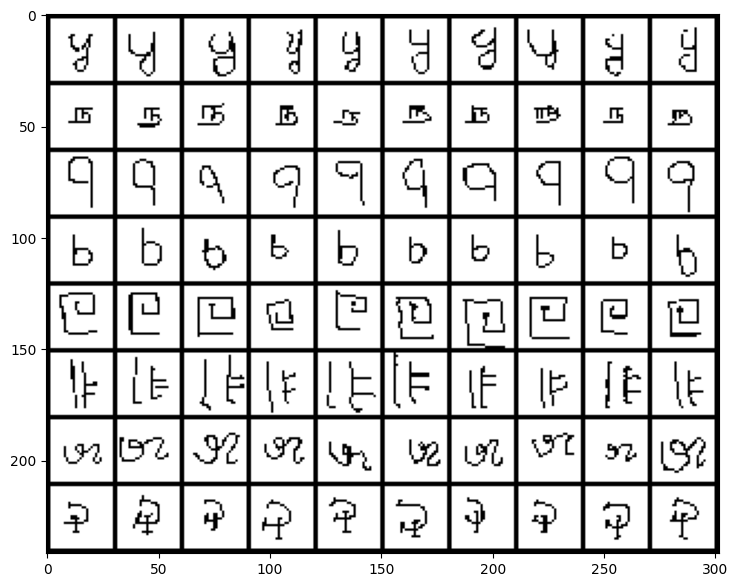

In [11]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [12]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [13]:
def get_submodule(in_channels, out_channels, kernel_size = 3):
    padding = kernel_size // 2
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

def get_encoder(x_dim, hid_dim, z_dim):
    return nn.Sequential(
        get_submodule(x_dim, hid_dim),
        get_submodule(hid_dim, hid_dim),
        get_submodule(hid_dim, hid_dim),
        get_submodule(hid_dim, z_dim)
    )

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [14]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        sample_images = sample_images.to('cuda')
        sample_images = sample_images.view(n_way * (n_support + n_query), *sample_images.shape[-3:])

        # img2vec results
        vectors = self.encoder(sample_images).view(n_way, (n_support + n_query), -1)

        # центры тяжести класстеров классов
        prototypes = vectors[:, :n_support].mean(1)

        # ищем расстояния от каждого изображения из query до каждого центра тяжести
        queries = vectors[:, n_support:].contiguous().view(-1, vectors.shape[-1])
        query_dists = list()
        for query in queries:
            prototype_dists = torch.stack([torch.sqrt(torch.pow(query - prototype, 2).sum()) for prototype in prototypes])
            query_dists.append(prototype_dists)
        query_dists = torch.stack(query_dists)

        probabilities = F.log_softmax(-query_dists, dim=1).view(n_way, n_query, -1)

        _, y_hat = probabilities.max(2)

        losses = list()
        n_true_positive = 0
        for way in range(n_way):
            for query in range(n_query):
            losses.append(-probabilities[way][query][way])
            if y_hat[way][query] == way:
                n_true_positive += 1
        loss_val = torch.stack(losses).mean()
        acc = n_true_positive / (n_way * n_query)

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc,
            'y_hat': y_hat
            }

In [15]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = get_encoder(kwargs['x_dim'][0], kwargs['hid_dim'], kwargs['z_dim'])

    return ProtoNet(encoder)

In [16]:
model = load_protonet_conv(**{'x_dim':(3, 28, 28), 'hid_dim':64, 'z_dim':64})

In [17]:
model.set_forward_loss(sample_example)

C:\Users\L-110\anaconda3\envs\ml_env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


(tensor(1.5121, device='cuda:0', grad_fn=<MeanBackward0>),
 {'loss': 1.5120936632156372,
  'acc': 0.575,
  'y_hat': tensor([[0, 4, 6, 7, 0],
          [1, 1, 1, 1, 1],
          [4, 0, 4, 4, 2],
          [3, 3, 3, 1, 0],
          [4, 5, 4, 0, 4],
          [4, 0, 2, 5, 5],
          [6, 6, 4, 3, 6],
          [7, 7, 7, 2, 7]], device='cuda:0')})

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [18]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    # wandb.watch(model)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        # wandb.log({'Epoch': epoch + 1, 'Loss': round(epoch_loss, 4), 'Acc': round(epoch_acc, 4)})
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()

In [67]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 25
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 2
epoch_size = 300

In [68]:
%%time

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 train:   0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\L-110\anaconda3\envs\ml_env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 -- Loss: 0.2896 Acc: 0.9390


Epoch 2 train:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0878 Acc: 0.9819
CPU times: total: 17min 43s
Wall time: 22min 51s


## Test

In [22]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']

    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [69]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

5-way 5-shot

In [27]:
print('test: 5-way 5-shot')
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0239 Acc: 0.9928


5-way 1-shot

In [28]:
print('test: 5-way 1-shot')
test(model, test_x, test_y, 5, 1, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0965 Acc: 0.9694


20-way 1-shot

In [29]:
print('test: 20-way 1-shot')
test(model, test_x, test_y, 20, 1, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.2832 Acc: 0.9111


20-way 5-shot

In [30]:
print('test: 20-way 5-shot')
test(model, test_x, test_y, 20, 5, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0912 Acc: 0.9745


## Test on specific example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


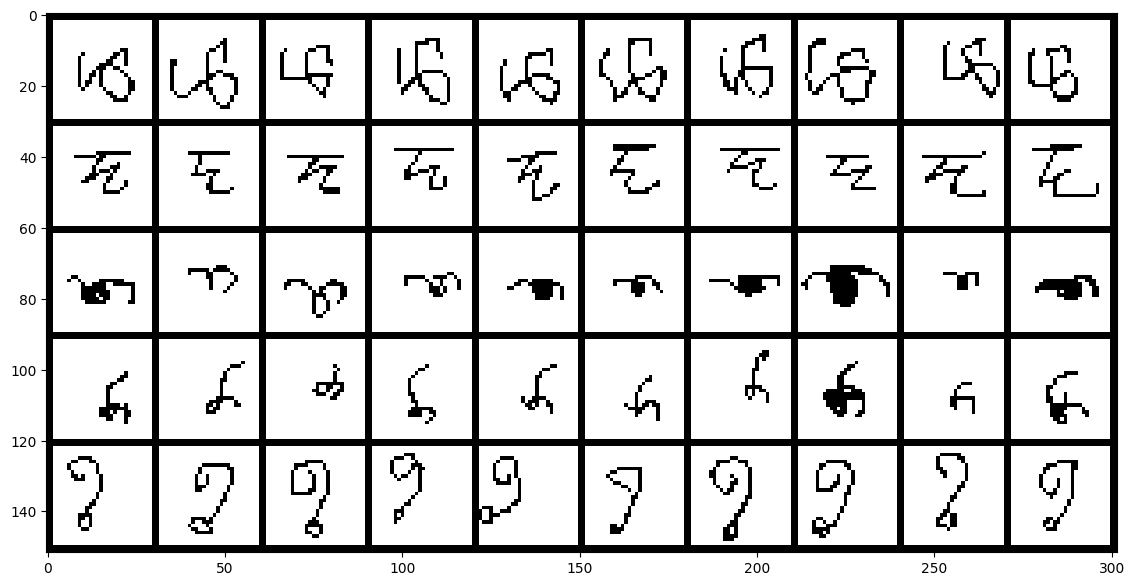

In [70]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [71]:
from sklearn.manifold import TSNE


def show_predictions(sample, encoder):
    sample_images = sample['images']
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    sample_images = sample_images.to('cuda')
    sample_images = sample_images.view(n_way * (n_support + n_query), *sample_images.shape[-3:])

    # img2vec results
    vectors = encoder(sample_images).view(n_way, (n_support + n_query), -1)

    # центры тяжести класстеров классов
    prototypes = vectors[:, :n_support].mean(1)
    prototypes = prototypes.cpu().detach().numpy()
    
    queries = vectors[:, n_support:].cpu().detach().numpy()
    
    prototypes = np.expand_dims(prototypes, axis=1)
    
    feats = np.concatenate([prototypes, queries], axis=1)
    feats = feats.reshape(-1, vectors.shape[-1])

    print('Train TSNE ... ')
    tsne = TSNE(n_components=2, perplexity=5, n_jobs=4)
    x_feats = tsne.fit_transform(feats)
    
    print('Plot labels ...')

    fig = plt.figure(figsize=(10, 8))

    colors = []

    for i in range(n_way):
        color = plt.cm.tab10(i / float(n_way))
        plt.scatter(x_feats[(n_query + 1) * i, 0], x_feats[(n_query + 1) * i, 1], marker='*', color=color)
        colors.append(color)
        
    for i in range(n_way):
        plt.scatter(x_feats[(n_query + 1) * i + 1:(n_query + 1) * (i + 1), 0], x_feats[(n_query + 1) * i + 1: (n_query + 1) * (i + 1), 1], color=colors[i])

        
    plt.legend([str(i) for i in range(n_way)])
    plt.grid(True)
    plt.tight_layout()
    plt.close()
    return fig

Train TSNE ... 
Plot labels ...


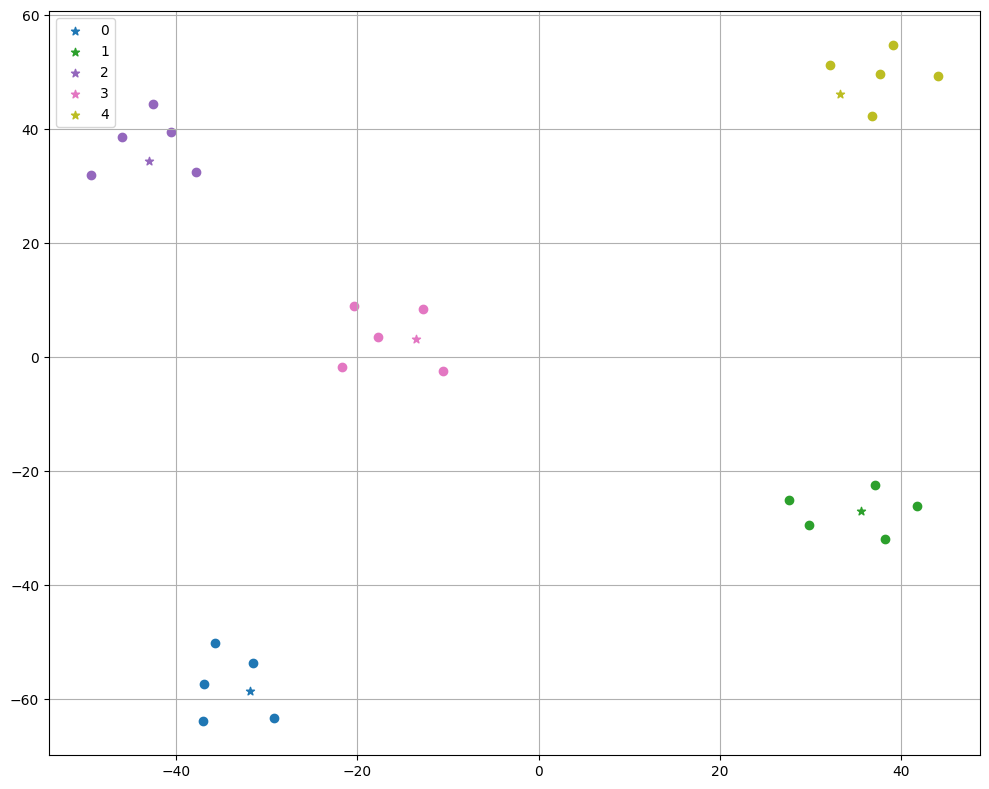

In [72]:
show_predictions(my_sample, model.encoder)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import albumentations as A
import yaml
import random
from albumentations.pytorch import ToTensorV2
from for_task6.cifar import load_cifar10
from PIL import Image

#from for_task6.train_class import BaseTrainProcess, SimCLRTrainProcess

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data", channels_last=True)
X_test_train, X_test_val, y_test_train, y_test_val = train_test_split(X_test, y_test, test_size=0.3)

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])


In [40]:
MEAN = tuple(np.mean(X_train, axis=(0, 1, 2), keepdims=True, dtype=float).squeeze())
STD = tuple(np.std(X_train, axis=(0, 1, 2), keepdims=True, dtype=float).squeeze())

train_transform = A.Compose([
    A.OneOf([
        A.ColorJitter(),
        A.ToGray(),
#         A.GaussNoise(),
    ]),
#     A.OneOf([
#         A.Cutout(num_holes=1, max_h_size=10, max_w_size=10),
#         A.RandomResizedCrop(32, 32),
#         A.GaussianBlur(),
#     ]),
    A.HorizontalFlip(),
#     A.RandomRotate90(),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

In [45]:
with open('./for_task6/hyp_params.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)

set_seed(hyps['seed'])

trainer = SimCLRTrainProcess(hyps)
trainer.device = 'cuda'
trainer.init_params(X_train, y_train, X_val, y_val, train_transform, valid_transform)

Train size: 40000 Valid size: 10000


In [46]:
train_losses, valid_losses = trainer.run()

Valid 1/1, Loss: 2.940: 100%|████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.02it/s]


In [72]:
from for_task6.model import ProjectionHead

class NewСlassifier(nn.Module):
    def __init__(self, encoder, emb_size, class_num = 10):
        super(NewСlassifier, self).__init__()
        self.encoder = encoder
        
        for p in self.encoder.parameters():
            p.requires_grad = False
        
        self.projector = ProjectionHead(emb_size, 2048, class_num)
    
    def forward(self,x):
        out = self.encoder(x)
        xp = self.projector(torch.squeeze(out))
        return xp
    
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform_augment=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform_augment = transform_augment
                    
    def __len__(self):
        return len(self.x_data) 
    
    def __getitem__(self, item):
        image = self.x_data[item]
        label = self.y_data[item]
        
        if self.transform_augment is not None:
            image = (image * 255).astype(np.uint8)
            image = self.transform_augment(image=image)['image']
        else:
            image = torch.tensor(image, dtype=torch.float32)
            image = image.permute(2, 0, 1)  # switch to dim, h, w
        
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [73]:
class NewClassifierTrainProcess(BaseTrainProcess):
    def __init__(self, hyp, encoder, emb_size):
        super(NewClassifierTrainProcess, self).__init__(hyp)
        self.encoder = encoder
        self.emb_size = emb_size
        
    def _inner_init_data(self, X_train, y_train, X_val, y_val, train_transform, valid_transform):
        train_dataset = CustomDataset(X_train, y_train, train_transform)
        valid_dataset = CustomDataset(X_val, y_val, valid_transform)
        return train_dataset, valid_dataset
    
    def _inner_init_model(self):
        self.model = NewСlassifier(self.encoder, self.emb_size)
        self.model.to(self.device)

    def _inner_init_scheduler(self):
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min')
        
    def _inner_init_criterion(self):
        self.criterion = nn.CrossEntropyLoss().to(self.device)

    def _inner_train_step(self, pbar):
        cum_loss = 0.0
        proc_loss = 0.0
        for idx, (x, y) in pbar:
            x, y = x.to(self.device), y.to(self.device)

            with torch.set_grad_enabled(True):
                out = self.model(x)
                loss = self.criterion(out, y)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.model.zero_grad()

            cur_loss = loss.detach().cpu().numpy()
            cum_loss += cur_loss

            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)

            s = f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}, Loss: {proc_loss:4.3f}'
            pbar.set_description(s)

        return cum_loss

    def _inner_valid_step(self, pbar):
        cum_loss = 0.0
        proc_loss = 0.0
        for idx, (x, y) in pbar:
            x, y = x.to(self.device), y.to(self.device)

            with torch.set_grad_enabled(False):
                out = self.model(x)
                loss = self.criterion(out, y)

            cur_loss = loss.detach().cpu().numpy()
            cum_loss += cur_loss

            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)

            s = f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}, Loss: {proc_loss:4.3f}'
            pbar.set_description(s)

        return cum_loss
    
    def scheduler_step(self):
        if self.train_losses:
            self.lr_scheduler.step(self.train_losses[-1][0])

#### обучение со специально обученным энкодером

In [74]:
with open('./for_task6/hyp_params.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)

set_seed(hyps['seed'])

new_trainer = NewClassifierTrainProcess(hyps, trainer.model.encoder, trainer.model.emb_size)
new_trainer.device = 'cuda'
new_trainer.init_params(X_test_train, y_test_train, X_test_val, y_test_val, valid_transform, valid_transform)

Train size: 7000 Valid size: 3000


In [75]:
new_train_losses, new_valid_losses = new_trainer.run()

Valid 1/1, Loss: 2.011: 100%|██████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 44.78it/s]


#### обучение с необученным специально энкодером

In [76]:
from for_task6.model import PreModel
m = PreModel()

with open('./for_task6/hyp_params.yaml', 'r') as f:
    hyps = yaml.load(f, Loader=yaml.SafeLoader)

set_seed(hyps['seed'])

new_trainer_with_simple_encoder = NewClassifierTrainProcess(hyps, m.encoder, m.emb_size)
new_trainer_with_simple_encoder.device = 'cuda'
new_trainer_with_simple_encoder.init_params(X_test_train, y_test_train, X_test_val, y_test_val, valid_transform, valid_transform)

Train size: 7000 Valid size: 3000


In [77]:
new_train_losses_simple_encoder, new_valid_losses_simple_encoder = new_trainer_with_simple_encoder.run()

Valid 1/1, Loss: 1.594: 100%|██████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 45.09it/s]
